# **Detektor Plat Nomer Kendaraan Indoesia dengan Algoritma Yolov8**

### **Abstrak**

Penelitian ini bertujuan untuk mengembangkan dan mengevaluasi model deteksi plat nomor kendaraan menggunakan algoritma YOLOv8 (You Only Look Once versi 8). Model dilatih pada dataset berisi citra kendaraan dengan plat nomor menggunakan format YOLO yang telah melalui proses normalisasi koordinat. Selama tahap pelatihan, model mencapai performa yang sangat baik pada data validasi dengan nilai precision sebesar 98.29%, recall sebesar 95.78%, mAP@50 sebesar 98.74%, dan mAP@50-95 sebesar 95.34%. Nilai fitness model selama pelatihan tercatat sebesar 95.68%.

Selanjutnya, model diuji pada dataset uji (test set) untuk menilai kemampuan generalisasi terhadap data yang belum pernah dilihat sebelumnya. Hasil evaluasi pada test set menunjukkan performa yang sangat baik dengan precision sebesar 98.27%, recall sebesar 100%, mAP@50 sebesar 98.98%, dan mAP@50-95 sebesar 93.93%, dengan nilai fitness sebesar 94.43%. Model juga menunjukkan waktu inferensi yang cepat, sehingga layak untuk diterapkan pada sistem deteksi plat nomor secara real-time. Hasil ini mengindikasikan bahwa YOLOv8 mampu mendeteksi plat nomor kendaraan dengan akurasi dan kecepatan tinggi, serta dapat diimplementasikan untuk mendukung sistem pengawasan atau otomatisasi berbasis visi komputer.

# **Data Wrangling**

## Install Library

In [1]:
!nvidia-smi

Mon Jul  7 13:21:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   70C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install roboflow

In [3]:
!pip install ultralytics

In [4]:
!pip install easyocr ultralytics

## Import Library

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
from roboflow import Roboflow
from PIL import Image
import pandas as pd
import cv2
import random
import zipfile

plt.rcParams['figure.figsize'] = [15, 30]

## Dwonload data

In [ ]:
# Dwonload data from Roboflow
rf = Roboflow(api_key="n4Jb4ewaBFmL1d05b16s")
project = rf.workspace("denny-pmzkg").project("plat-nomor-kendaraan-indonesia")
version = project.version(2)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Plat-nomor-kendaraan-Indonesia-2 in yolov8:: 100%|██████████| 1186/1186 [00:01<00:00, 754.31it/s] 


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Data loading

In [ ]:
# @title Baca data
# Path ke dataset
base_dir = 'Plat-nomor-kendaraan-Indonesia-2'

# Hitung file gambar di setiap folder
def count_images(folder):
    image_dir = os.path.join(base_dir, folder, 'images')
    return len([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])

n_train = count_images('train')
n_val = count_images('valid')
n_test = count_images('test')

total = n_train + n_val + n_test

# Print hasil
print(f"Train : {n_train} ({n_train/total:.2%})")
print(f"Valid : {n_val} ({n_val/total:.2%})")
print(f"Test  : {n_test} ({n_test/total:.2%})")
print(f"Total : {total}")

Train : 411 (70.02%)
Valid : 117 (19.93%)
Test  : 59 (10.05%)
Total : 587


In [ ]:
# @title Cek dan buang data aneh
# Cek gambar corrupt
image_dir = 'Plat-nomor-kendaraan-Indonesia-2/train/images'
label_dir = 'Plat-nomor-kendaraan-Indonesia-2/train/labels'

bad_images = []
for file in os.listdir(image_dir):
    if file.endswith(('.jpg', '.png', '.jpeg')):
        try:
            img = Image.open(os.path.join(image_dir, file))
            img.verify()  # cek corrupt
        except:
            bad_images.append(file)

print("Corrupt image files:", bad_images)

# Cek label kosong
empty_labels = []
for file in os.listdir(label_dir):
    if file.endswith('.txt'):
        with open(os.path.join(label_dir, file), 'r') as f:
            if len(f.read().strip()) == 0:
                empty_labels.append(file)

print("Empty label files:", empty_labels)

Corrupt image files: []
Empty label files: ['plat-414-_jpg.rf.c92936e8d3ae9a45ea07229247a471e1.txt', 'plat-567-_jpg.rf.f139c5276cafe8c7ece96c64e224e25b.txt', 'plat-500-_jpg.rf.034cf4661e959cc0a97b0b366dd638f3.txt', 'plat-524-_jpg.rf.9cc1f8368f4ae1505ef40e60cb40f251.txt']


# **Ekplorasi Data Analisis**

Train : 411 (70.02%)
Valid : 117 (19.93%)
Test  : 59 (10.05%)
Total : 587


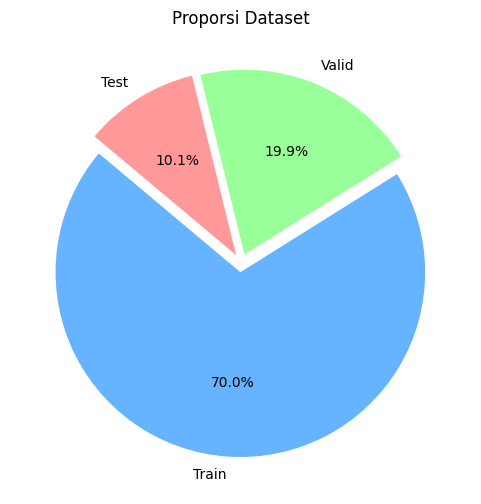

In [ ]:
# @title Distribusi dataset

# Path dataset
base_dir = 'Plat-nomor-kendaraan-Indonesia-2'

# Hitung file gambar di setiap folder
def count_images(folder):
    image_dir = os.path.join(base_dir, folder, 'images')
    return len([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])

# Hitung jumlah
n_train = count_images('train')
n_val = count_images('valid')
n_test = count_images('test')

total = n_train + n_val + n_test

# Print hasil
print(f"Train : {n_train} ({n_train/total:.2%})")
print(f"Valid : {n_val} ({n_val/total:.2%})")
print(f"Test  : {n_test} ({n_test/total:.2%})")
print(f"Total : {total}")

# Pie chart
labels = ['Train', 'Valid', 'Test']
sizes = [n_train, n_val, n_test]
colors = ['#66b3ff', '#99ff99', '#ff9999']

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, explode=(0.05, 0.05, 0.05))
plt.title('Proporsi Dataset')
plt.show()


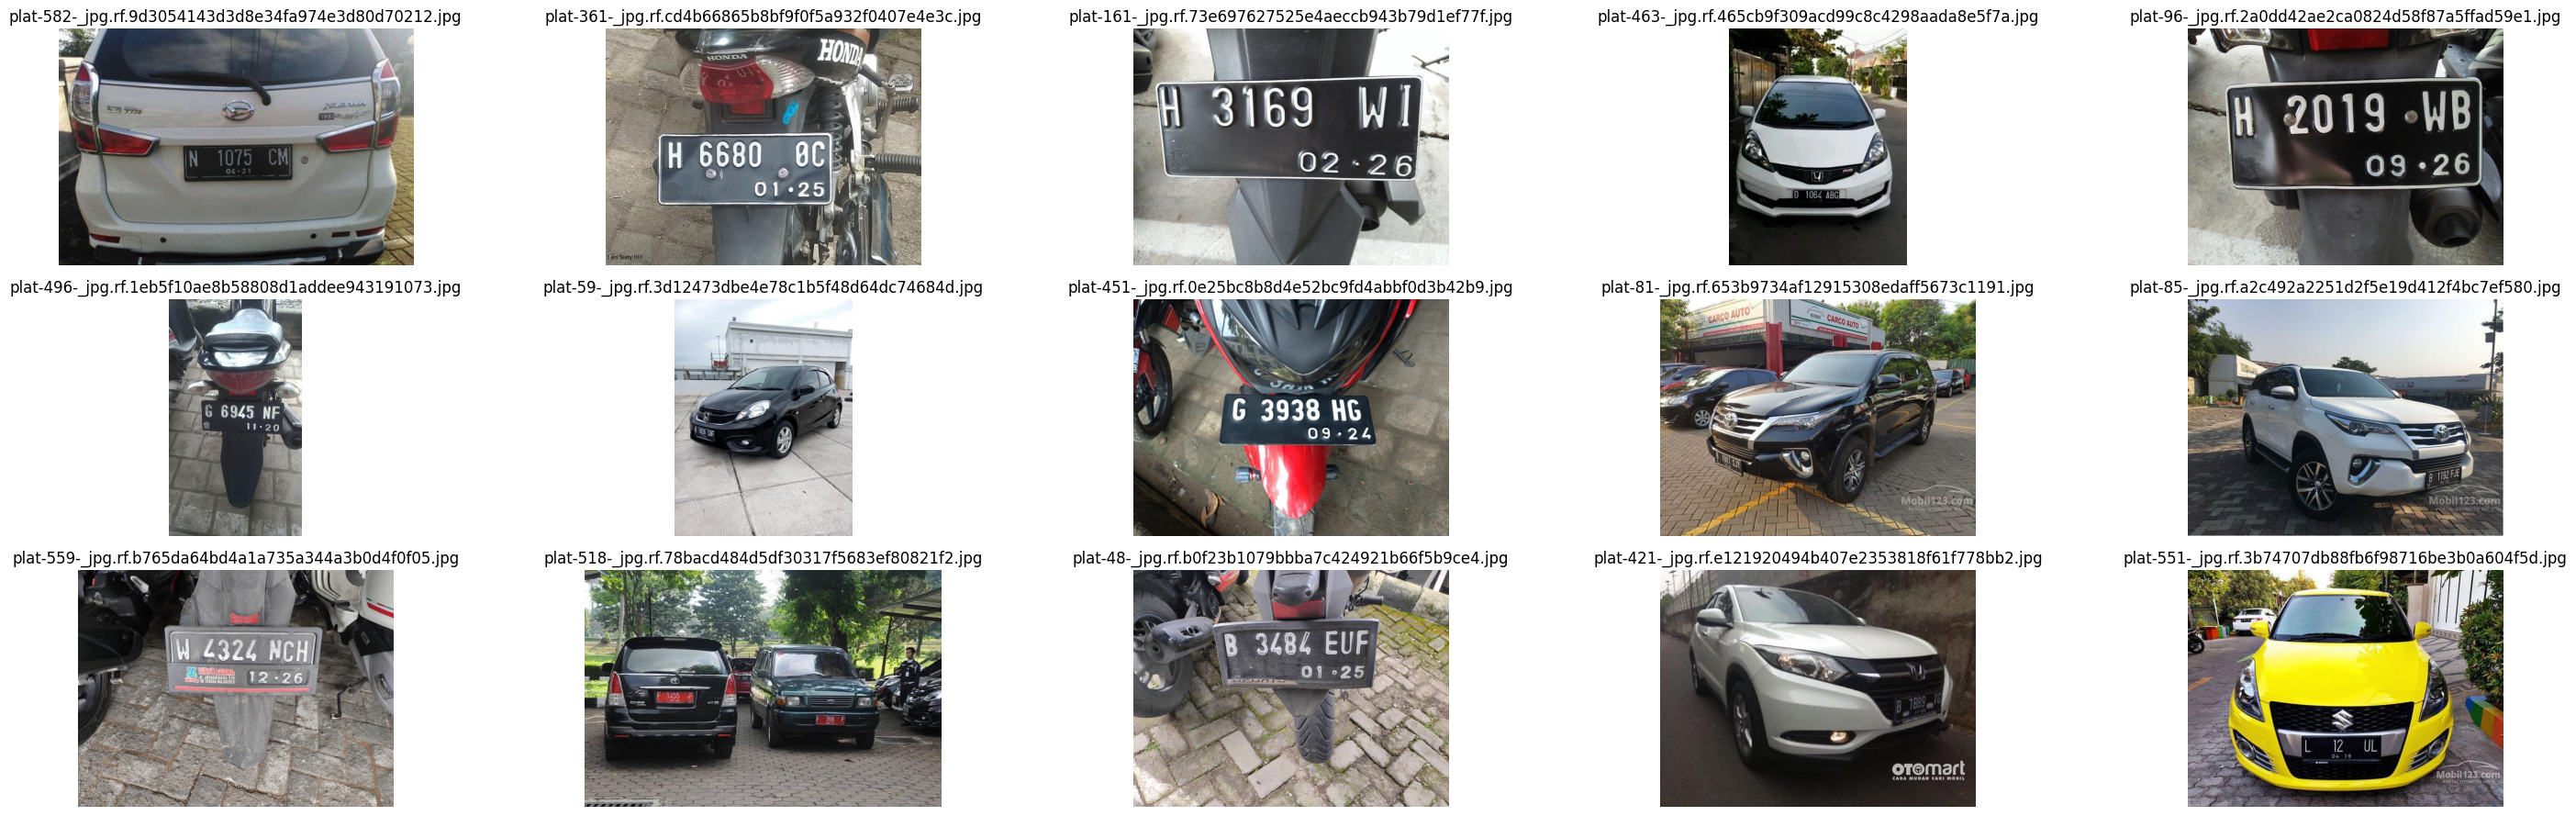

In [ ]:
# @title Show foto plat

# Path ke folder gambar training
train_dir = 'Plat-nomor-kendaraan-Indonesia-2/train/images'

# List semua file gambar
image_files = [os.path.join(train_dir, f) for f in os.listdir(train_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Tentukan berapa gambar random yang mau ditampilkan
n_samples = 15

# Ambil n_samples gambar random
sample_files = random.sample(image_files, n_samples)

# Tentukan grid
cols = 5
rows = (n_samples + cols - 1) // cols

plt.figure(figsize=(30, rows * 3))
for i, filepath in enumerate(sample_files):
    img = Image.open(filepath)
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(filepath))  # Bisa ganti sesuai nama file
    plt.axis('off')

plt.tight_layout()
plt.show()

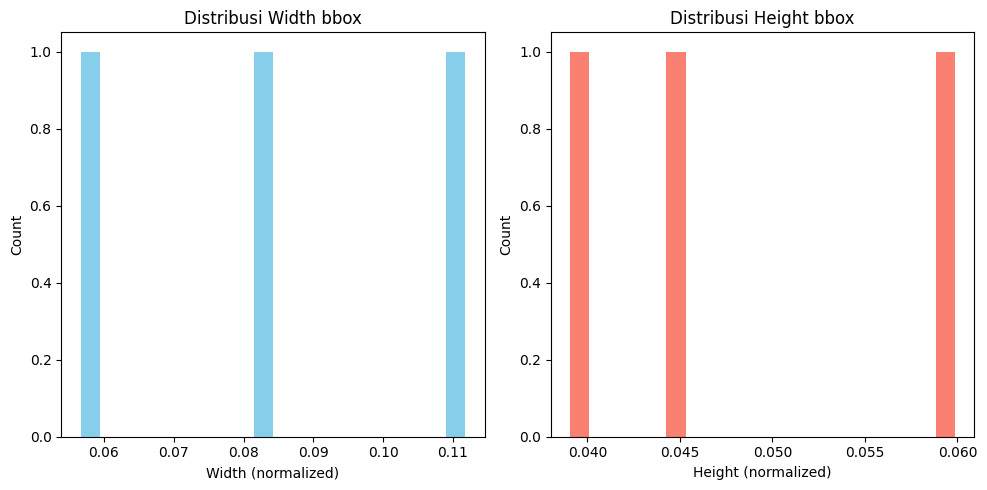

In [ ]:
# @title Distribusi ukuran bounding box

label_dir = 'Plat-nomor-kendaraan-Indonesia-2/train/labels'

widths = []
heights = []

for file in os.listdir(label_dir):
    if file.endswith('.txt'):
        with open(os.path.join(label_dir, file), 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:  # YOLO bbox
                    _, x_center, y_center, w, h = map(float, parts)
                    widths.append(w)
                    heights.append(h)

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.hist(widths, bins=20, color='skyblue')
plt.title('Distribusi Width bbox')
plt.xlabel('Width (normalized)')
plt.ylabel('Count')

plt.subplot(1,2,2)
plt.hist(heights, bins=20, color='salmon')
plt.title('Distribusi Height bbox')
plt.xlabel('Height (normalized)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

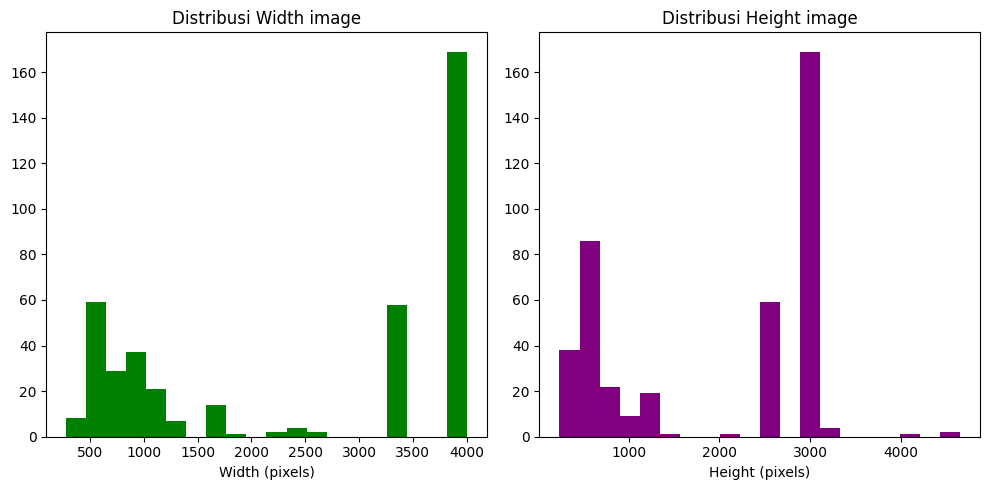

In [ ]:
# @title Variasi ukuran gambar
image_dir = 'Plat-nomor-kendaraan-Indonesia-2/train/images'
widths_img = []
heights_img = []

for file in os.listdir(image_dir):
    if file.endswith(('.jpg', '.png', '.jpeg')):
        img = Image.open(os.path.join(image_dir, file))
        widths_img.append(img.width)
        heights_img.append(img.height)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(widths_img, bins=20, color='green')
plt.title('Distribusi Width image')
plt.xlabel('Width (pixels)')

plt.subplot(1,2,2)
plt.hist(heights_img, bins=20, color='purple')
plt.title('Distribusi Height image')
plt.xlabel('Height (pixels)')

plt.tight_layout()
plt.show()


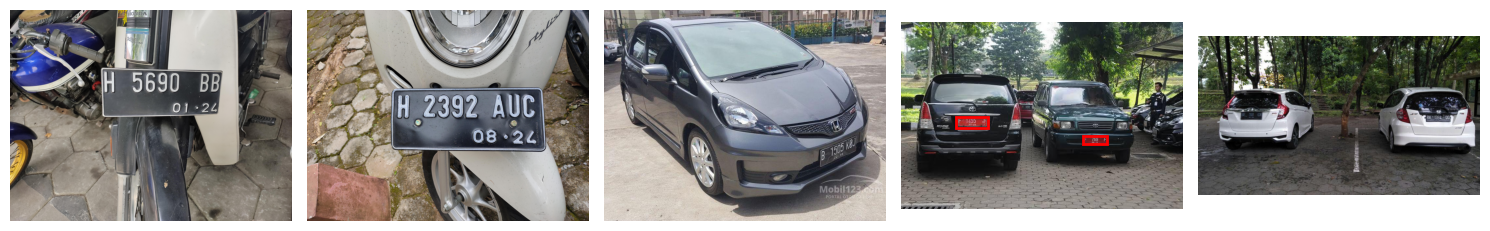

In [ ]:
# @title Contoh visual bbox + gambar
def draw_yolo_bbox(img_path, label_path):
    img = Image.open(img_path)
    w_img, h_img = img.size

    plt.imshow(img)

    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                _, x, y, w, h = map(float, parts)
                # convert ke pixel
                x *= w_img
                y *= h_img
                w *= w_img
                h *= h_img
                # kotak
                rect = plt.Rectangle(
                    (x - w/2, y - h/2),
                    w, h,
                    edgecolor='red', facecolor='none', linewidth=2
                )
                plt.gca().add_patch(rect)
    plt.axis('off')

# Tampilkan 5 gambar random
sample_files = random.sample(os.listdir(image_dir), 5)

plt.figure(figsize=(15, 6))
for i, f in enumerate(sample_files):
    img_path = os.path.join(image_dir, f)
    label_path = os.path.join(label_dir, f.replace('.jpg', '.txt').replace('.png', '.txt').replace('.jpeg', '.txt'))
    plt.subplot(1, 5, i+1)
    draw_yolo_bbox(img_path, label_path)

plt.tight_layout()
plt.show()

# **Preprocesing**

In [ ]:
# @title konversi label training segmentasi ke bounding box

def convert_polygon_to_bbox(input_label_folder, output_label_folder):
    """
    Mengonversi label polygon YOLO ke format bbox (x_center, y_center, width, height)

    Args:
        input_label_folder (str): Path folder label input (polygon)
        output_label_folder (str): Path folder label output (bbox)

    """
    os.makedirs(output_label_folder, exist_ok=True)

    for filename in os.listdir(input_label_folder):
        if filename.endswith('.txt'):
            input_path = os.path.join(input_label_folder, filename)
            output_path = os.path.join(output_label_folder, filename)

            with open(input_path, 'r') as f:
                lines = f.readlines()

            new_lines = []
            for line in lines:
                parts = line.strip().split()
                cls = parts[0]
                coords = list(map(float, parts[1:]))

                # Reshape jadi (N, 2)
                points = np.array(coords).reshape(-1, 2)

                # Cari bbox
                x_min = np.min(points[:, 0])
                x_max = np.max(points[:, 0])
                y_min = np.min(points[:, 1])
                y_max = np.max(points[:, 1])

                x_center = (x_min + x_max) / 2
                y_center = (y_min + y_max) / 2
                width = x_max - x_min
                height = y_max - y_min

                new_line = f"{cls} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"
                new_lines.append(new_line)

            with open(output_path, 'w') as f:
                for nl in new_lines:
                    f.write(nl + '\n')

    print(f"✅ Konversi selesai! Label baru ada di folder: {output_label_folder}")

In [ ]:
# @title Proses konversi
convert_polygon_to_bbox(
    input_label_folder='Plat-nomor-kendaraan-Indonesia-2/train/labels',
    output_label_folder='Plat-nomor-kendaraan-Indonesia-2/train/labels_bbox'
)

convert_polygon_to_bbox(
    input_label_folder='Plat-nomor-kendaraan-Indonesia-2/valid/labels',
    output_label_folder='Plat-nomor-kendaraan-Indonesia-2/valid/labels_bbox'
)

convert_polygon_to_bbox(
    input_label_folder='Plat-nomor-kendaraan-Indonesia-2/test/labels',
    output_label_folder='Plat-nomor-kendaraan-Indonesia-2/test/labels_bbox'
)

✅ Konversi selesai! Label baru ada di folder: Plat-nomor-kendaraan-Indonesia-2/train/labels_bbox
✅ Konversi selesai! Label baru ada di folder: Plat-nomor-kendaraan-Indonesia-2/valid/labels_bbox
✅ Konversi selesai! Label baru ada di folder: Plat-nomor-kendaraan-Indonesia-2/test/labels_bbox


### Keterangan Augmentasi & Resize Manual

✅ **Tidak dilakukan augmentasi manual tambahan**
YOLOv8 sudah memiliki fitur built-in augmentasi saat proses training. Beberapa augmentasi yang secara otomatis diterapkan di antaranya:

* Horizontal flip
* Scale (perbesaran/perkecilan objek)
* Rotation kecil
* Color space augmentation (perubahan kecerahan, kontras)
* Mosaic augmentation

✅ **Tidak dilakukan resize manual gambar**
YOLOv8 secara otomatis melakukan resize gambar saat training sesuai dengan ukuran `imgsz` yang ditentukan dalam konfigurasi (default 640×640 piksel).
Setiap gambar akan otomatis diubah ukurannya tanpa perlu dilakukan resize sebelumnya.

🌟 **Alasan**

* Dataset dari Roboflow telah disiapkan dengan ukuran gambar yang seragam (sesuai setting saat unduh dataset).
* Label sudah dalam format YOLO (center\_x, center\_y, width, height dalam bentuk normalisasi), sehingga tetap valid meskipun gambar di-resize otomatis oleh YOLOv8.


In [ ]:
# @title Augmentasi Data
# import albumentations as A
# import cv2
# import os

# # Path
# image_dir = 'Plat-nomor-kendaraan-Indonesia-2/train/images'
# label_dir = 'Plat-nomor-kendaraan-Indonesia-2/train/labels_bbox'
# output_img_dir = 'Data_final/images_aug'
# output_lbl_dir = 'Data_final/labels_aug'
# os.makedirs(output_img_dir, exist_ok=True)
# os.makedirs(output_lbl_dir, exist_ok=True)

# # Transform
# transform = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.2),
#     A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.1, rotate_limit=10, p=0.5),
# ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# # Loop gambar
# for file in os.listdir(image_dir):
#     if file.endswith(('.jpg', '.png', '.jpeg')):
#         img_path = os.path.join(image_dir, file)
#         lbl_path = os.path.join(label_dir, file.replace('.jpg','.txt').replace('.png','.txt').replace('.jpeg','.txt'))

#         # Baca gambar
#         img = cv2.imread(img_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         h, w = img.shape[:2]

#         # Baca bbox
#         bboxes = []
#         class_labels = []
#         if os.path.exists(lbl_path):
#             with open(lbl_path, 'r') as f:
#                 for line in f:
#                     parts = line.strip().split()
#                     if len(parts) == 5:
#                         cls, x, y, bw, bh = parts
#                         bboxes.append([float(x), float(y), float(bw), float(bh)])
#                         class_labels.append(cls)

#         # Apply augment
#         augmented = transform(image=img, bboxes=bboxes, class_labels=class_labels)

#         # Simpan gambar
#         out_img = cv2.cvtColor(augmented['image'], cv2.COLOR_RGB2BGR)
#         out_img_path = os.path.join(output_img_dir, file)
#         cv2.imwrite(out_img_path, out_img)

#         # Simpan label
#         out_lbl_path = os.path.join(output_lbl_dir, file.replace('.jpg','.txt').replace('.png','.txt').replace('.jpeg','.txt'))
#         with open(out_lbl_path, 'w') as f:
#             for bbox, cls in zip(augmented['bboxes'], augmented['class_labels']):
#                 f.write(f"{cls} {' '.join(map(str, bbox))}\n")

# print("Augmentasi selesai!")

# **Modeling**

In [ ]:
from ultralytics import YOLO

# Load model YOLOv8 (boleh pilih: yolov8n.pt, yolov8s.pt, yolov8m.pt, yolov8l.pt, yolov8x.pt)
model = YOLO("yolov8n.pt")  # nano, ringan & cepat untuk start

# Training
model.train(
    data="Plat-nomor-kendaraan-Indonesia-2/data.yaml",      # path ke dataset yaml
    epochs=100,            # jumlah epoch
    imgsz=640,             # ukuran gambar input
    batch=16,              # sesuaikan dengan RAM/GPU
    name="yolo8-plat"      # nama eksperimen (output di runs/detect/yolo8-plat)
)

100%|██████████| 6.25M/6.25M [00:00<00:00, 302MB/s]


Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Plat-nomor-kendaraan-Indonesia-2/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo8-plat, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, p

100%|██████████| 755k/755k [00:00<00:00, 79.0MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

 22        [15, 18, 21]  1    751507  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 106MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.1 ms, read: 1157.4±916.3 MB/s, size: 729.2 KB)


train: Scanning /content/Plat-nomor-kendaraan-Indonesia-2/train/labels... 411 images, 4 backgrounds, 0 corrupt: 100%|██████████| 411/411 [00:00<00:00, 2052.63it/s]

train: New cache created: /content/Plat-nomor-kendaraan-Indonesia-2/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 464.1±249.7 MB/s, size: 609.9 KB)


val: Scanning /content/Plat-nomor-kendaraan-Indonesia-2/valid/labels... 117 images, 0 backgrounds, 0 corrupt: 100%|██████████| 117/117 [00:00<00:00, 1370.94it/s]

val: New cache created: /content/Plat-nomor-kendaraan-Indonesia-2/valid/labels.cache


Plotting labels to runs/detect/yolo8-plat/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolo8-plat
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.02G      0.725      2.113      1.036         23        640: 100%|██████████| 26/26 [00:28<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]

                   all        117        120          1      0.144      0.854      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.24G     0.6633      1.165     0.9352         24        640: 100%|██████████| 26/26 [00:21<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        117        120      0.935      0.601      0.798      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.26G     0.6819       1.07     0.9447         26        640: 100%|██████████| 26/26 [00:20<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        117        120      0.836      0.742      0.835      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.28G     0.6983      1.042     0.9416         21        640: 100%|██████████| 26/26 [00:18<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        117        120      0.744      0.767       0.82      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       2.3G     0.6795     0.9321      0.951         28        640: 100%|██████████| 26/26 [00:21<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        117        120      0.536      0.702      0.601      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.31G     0.6479     0.8284     0.9502         20        640: 100%|██████████| 26/26 [00:18<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]

                   all        117        120      0.876      0.708      0.843       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.33G     0.6681     0.7853     0.9385         22        640: 100%|██████████| 26/26 [00:18<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        117        120      0.911      0.683      0.821        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.35G     0.6691       0.72     0.9371         35        640: 100%|██████████| 26/26 [00:20<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        117        120      0.917        0.8      0.877       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.37G     0.6201     0.6731     0.9284         25        640: 100%|██████████| 26/26 [00:18<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]

                   all        117        120      0.831      0.767      0.876      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.38G     0.6248      0.653     0.9103         30        640: 100%|██████████| 26/26 [00:22<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        117        120      0.972      0.942      0.977      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       2.4G     0.5967     0.6457     0.9291         20        640: 100%|██████████| 26/26 [00:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        117        120      0.972      0.862      0.941       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.42G     0.5949     0.6128      0.909         18        640: 100%|██████████| 26/26 [00:20<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

                   all        117        120      0.977      0.883      0.946      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.43G     0.5799     0.5519     0.9095         25        640: 100%|██████████| 26/26 [00:18<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]

                   all        117        120      0.991      0.943      0.989      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.45G     0.5816     0.5596     0.9128         24        640: 100%|██████████| 26/26 [00:19<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]

                   all        117        120      0.938      0.983       0.99      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.47G     0.5568     0.5479      0.927         29        640: 100%|██████████| 26/26 [00:18<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        117        120      0.991      0.958      0.983      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.48G     0.6039     0.5629     0.9129         26        640: 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

                   all        117        120      0.969        0.9      0.958       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       2.5G     0.5617     0.5285     0.9065         29        640: 100%|██████████| 26/26 [00:18<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]

                   all        117        120      0.987      0.908      0.958      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.52G      0.531     0.4812      0.885         30        640: 100%|██████████| 26/26 [00:18<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all        117        120      0.979      0.958      0.976      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.54G     0.5303     0.4787     0.8934         22        640: 100%|██████████| 26/26 [00:20<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

                   all        117        120      0.955      0.917      0.965      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.55G     0.5325     0.5016     0.9024         29        640: 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]

                   all        117        120      0.962      0.933      0.974      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.57G     0.5249     0.4879     0.8945         32        640: 100%|██████████| 26/26 [00:19<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

                   all        117        120      0.974      0.967      0.975      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.59G     0.4947     0.4343     0.8859         23        640: 100%|██████████| 26/26 [00:17<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all        117        120      0.983      0.958      0.962      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100       2.6G     0.5155     0.4629      0.895         33        640: 100%|██████████| 26/26 [00:18<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all        117        120      0.981      0.958      0.981      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.62G     0.5127     0.4627     0.8979         24        640: 100%|██████████| 26/26 [00:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]

                   all        117        120      0.981      0.967      0.992      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.64G     0.5084     0.4648      0.902         25        640: 100%|██████████| 26/26 [00:18<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        117        120      0.964      0.942      0.977      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.65G     0.4763     0.4315      0.882         18        640: 100%|██████████| 26/26 [00:18<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        117        120      0.984      0.967       0.99      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.67G     0.4988     0.4388     0.8811         24        640: 100%|██████████| 26/26 [00:19<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

                   all        117        120      0.991      0.956      0.985      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.69G     0.4957     0.4505     0.8949         23        640: 100%|██████████| 26/26 [00:19<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all        117        120      0.986      0.933      0.972      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.71G     0.4668     0.4399     0.8782         22        640: 100%|██████████| 26/26 [00:20<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        117        120      0.983      0.975      0.993      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.72G     0.4677     0.4056     0.8664         19        640: 100%|██████████| 26/26 [00:22<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]

                   all        117        120      0.991      0.975      0.985      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.74G     0.4533     0.3917     0.8648         18        640: 100%|██████████| 26/26 [00:20<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]

                   all        117        120      0.991      0.975      0.981      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.76G     0.4758     0.4206     0.8859         27        640: 100%|██████████| 26/26 [00:18<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]

                   all        117        120          1      0.948      0.958       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.78G     0.4461     0.3959     0.8777         26        640: 100%|██████████| 26/26 [00:18<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]

                   all        117        120      0.989      0.942      0.979      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.79G     0.4617     0.3937     0.8714         24        640: 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]

                   all        117        120      0.983       0.97      0.992      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.81G     0.4573     0.3936     0.8679         18        640: 100%|██████████| 26/26 [00:19<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all        117        120      0.958       0.95      0.984      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.83G     0.4452     0.3758     0.8643         22        640: 100%|██████████| 26/26 [00:18<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all        117        120      0.975      0.981      0.984      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.84G     0.4421     0.3834      0.848         22        640: 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.00it/s]

                   all        117        120      0.983      0.966      0.988      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.86G     0.4417     0.3736     0.8703         24        640: 100%|██████████| 26/26 [00:19<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        117        120      0.989      0.967      0.987      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.88G     0.4274     0.3834     0.8599         29        640: 100%|██████████| 26/26 [00:20<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]

                   all        117        120      0.977      0.975      0.988      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.89G     0.4193     0.3595     0.8696         23        640: 100%|██████████| 26/26 [00:18<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        117        120       0.96      0.958      0.977      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.91G     0.4268     0.3762     0.8673         20        640: 100%|██████████| 26/26 [00:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]

                   all        117        120      0.974       0.95      0.983      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.93G     0.4396     0.3838     0.8715         30        640: 100%|██████████| 26/26 [00:18<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]

                   all        117        120      0.977      0.967      0.983      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.95G      0.435     0.3831     0.8661         23        640: 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        117        120      0.991      0.967      0.988      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.96G     0.4086     0.3527     0.8626         22        640: 100%|██████████| 26/26 [00:19<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        117        120      0.991      0.975      0.992      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.98G      0.403     0.3319     0.8559         21        640: 100%|██████████| 26/26 [00:19<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

                   all        117        120      0.989      0.975      0.986      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         3G     0.4085     0.3565     0.8665         21        640: 100%|██████████| 26/26 [00:18<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all        117        120      0.991      0.949      0.983      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.01G     0.4068     0.3402     0.8608         26        640: 100%|██████████| 26/26 [00:20<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        117        120      0.988      0.975      0.984      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.03G     0.3903     0.3518     0.8654         22        640: 100%|██████████| 26/26 [00:21<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

                   all        117        120      0.967      0.963      0.982      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.05G     0.3834      0.335     0.8657         17        640: 100%|██████████| 26/26 [00:18<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        117        120      0.966      0.961      0.978      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.07G     0.3754     0.3416     0.8473         15        640: 100%|██████████| 26/26 [00:18<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        117        120      0.983      0.975       0.98      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.08G     0.4024     0.3407     0.8559         26        640: 100%|██████████| 26/26 [00:18<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

                   all        117        120       0.99       0.95      0.977      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       3.1G     0.3935     0.3341     0.8544         23        640: 100%|██████████| 26/26 [00:20<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]

                   all        117        120      0.972      0.925       0.96      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.12G     0.3827     0.3259     0.8545         18        640: 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

                   all        117        120      0.972      0.967      0.976      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.13G     0.3981     0.3348     0.8558         17        640: 100%|██████████| 26/26 [00:19<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

                   all        117        120      0.982      0.975      0.978      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.15G      0.381     0.3211     0.8616         23        640: 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        117        120      0.993      0.967      0.994      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.17G     0.3621     0.3151     0.8549         26        640: 100%|██████████| 26/26 [00:20<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        117        120      0.992      0.983      0.994      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.19G     0.3752     0.3186     0.8588         23        640: 100%|██████████| 26/26 [00:18<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        117        120      0.989      0.975      0.987      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       3.2G     0.3747     0.3153     0.8604         16        640: 100%|██████████| 26/26 [00:17<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        117        120      0.972      0.958      0.976      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.22G     0.3612     0.3054     0.8434         28        640: 100%|██████████| 26/26 [00:18<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        117        120      0.966      0.948      0.969      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.24G     0.3663     0.3136     0.8498         28        640: 100%|██████████| 26/26 [00:17<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        117        120      0.974      0.967      0.989      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.25G     0.3458     0.2954     0.8486         17        640: 100%|██████████| 26/26 [00:18<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        117        120      0.974      0.939       0.98      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.27G      0.357     0.3114     0.8519         20        640: 100%|██████████| 26/26 [00:18<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        117        120      0.982      0.958      0.982      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.29G     0.3585      0.301     0.8551         25        640: 100%|██████████| 26/26 [00:18<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        117        120      0.983      0.975      0.991      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       3.3G     0.3487     0.2963     0.8529         24        640: 100%|██████████| 26/26 [00:20<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        117        120       0.99      0.975      0.994       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.32G     0.3462     0.2936     0.8463         19        640: 100%|██████████| 26/26 [00:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]

                   all        117        120      0.988      0.983      0.994       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.34G     0.3594     0.2948     0.8569         27        640: 100%|██████████| 26/26 [00:19<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        117        120      0.992      0.988      0.994      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.35G     0.3393     0.2927     0.8411         22        640: 100%|██████████| 26/26 [00:21<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]

                   all        117        120      0.989      0.958      0.993      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.37G     0.3441     0.2925     0.8476         27        640: 100%|██████████| 26/26 [00:22<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        117        120      0.943      0.958      0.989      0.936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.39G     0.3481      0.284     0.8564         28        640: 100%|██████████| 26/26 [00:21<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

                   all        117        120      0.975      0.956      0.992      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.41G     0.3241     0.2765     0.8486         19        640: 100%|██████████| 26/26 [00:19<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

                   all        117        120      0.991      0.967      0.993      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.42G     0.3182     0.2775      0.842         23        640: 100%|██████████| 26/26 [00:19<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]

                   all        117        120      0.983      0.982      0.994      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.44G      0.332     0.3004     0.8474         30        640: 100%|██████████| 26/26 [00:20<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        117        120      0.981      0.958      0.992      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.46G     0.3102     0.2738     0.8444         22        640: 100%|██████████| 26/26 [00:20<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all        117        120      0.982      0.975      0.993      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.47G      0.324      0.268      0.845         20        640: 100%|██████████| 26/26 [00:19<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        117        120       0.99      0.967      0.985      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.49G     0.3248     0.2806     0.8438         25        640: 100%|██████████| 26/26 [00:19<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]

                   all        117        120      0.983      0.967      0.986      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.51G     0.3264     0.2738     0.8417         29        640: 100%|██████████| 26/26 [00:19<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all        117        120      0.979      0.967      0.972      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.53G     0.3183     0.2675     0.8395         24        640: 100%|██████████| 26/26 [00:20<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]

                   all        117        120      0.973      0.967      0.981      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.54G     0.3254     0.2668     0.8473         22        640: 100%|██████████| 26/26 [00:20<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

                   all        117        120       0.99       0.95      0.981      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.56G     0.3065     0.2664      0.844         25        640: 100%|██████████| 26/26 [00:20<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all        117        120      0.975      0.962      0.987      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.58G     0.3277     0.2706     0.8442         26        640: 100%|██████████| 26/26 [00:19<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        117        120      0.983      0.966      0.985      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.59G     0.3123     0.2613     0.8331         28        640: 100%|██████████| 26/26 [00:21<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all        117        120      0.983      0.965      0.989      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.61G     0.3031     0.2539     0.8429         22        640: 100%|██████████| 26/26 [00:21<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        117        120      0.982      0.958      0.982      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.63G      0.294     0.2484     0.8359         23        640: 100%|██████████| 26/26 [00:20<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

                   all        117        120      0.983      0.958      0.987      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.65G     0.2938     0.2463     0.8309         26        640: 100%|██████████| 26/26 [00:19<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        117        120      0.982      0.958      0.992       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.66G     0.2978     0.2468     0.8416         28        640: 100%|██████████| 26/26 [00:20<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

                   all        117        120      0.989      0.958      0.993      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.68G     0.2926     0.2364     0.8333         21        640: 100%|██████████| 26/26 [00:18<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

                   all        117        120       0.96      0.991      0.994      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100       3.7G     0.2993     0.2518      0.841         24        640: 100%|██████████| 26/26 [00:18<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        117        120      0.975      0.979      0.994      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.71G     0.2911     0.2452     0.8411         22        640: 100%|██████████| 26/26 [00:23<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]

                   all        117        120      0.981      0.975      0.993      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.73G     0.2895     0.2522     0.8243         26        640: 100%|██████████| 26/26 [00:21<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        117        120      0.983      0.966      0.993      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.75G     0.3066     0.2522     0.8521         25        640: 100%|██████████| 26/26 [00:21<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        117        120      0.963      0.975      0.992      0.945


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.77G     0.2553     0.2101     0.7896         11        640: 100%|██████████| 26/26 [00:28<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        117        120       0.99      0.958       0.99      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      3.78G     0.2429     0.2038     0.7863         11        640: 100%|██████████| 26/26 [00:22<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]

                   all        117        120      0.991      0.967      0.989      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       3.8G     0.2402     0.2014     0.7951         11        640: 100%|██████████| 26/26 [00:21<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]

                   all        117        120      0.991      0.967      0.989      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      3.82G     0.2371     0.2009     0.7963         11        640: 100%|██████████| 26/26 [00:22<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        117        120      0.991      0.965      0.989       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.83G     0.2415     0.1922     0.7884         10        640: 100%|██████████| 26/26 [00:20<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all        117        120      0.989      0.967       0.99      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.85G     0.2318     0.1893     0.7803         12        640: 100%|██████████| 26/26 [00:22<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        117        120       0.99       0.95      0.989      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.87G     0.2312     0.1875     0.7783         11        640: 100%|██████████| 26/26 [00:22<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all        117        120      0.991      0.956       0.99       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      3.89G     0.2279      0.192     0.7864         12        640: 100%|██████████| 26/26 [00:20<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        117        120      0.983      0.965      0.992      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100       3.9G      0.225     0.1868     0.7966         11        640: 100%|██████████| 26/26 [00:19<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all        117        120      0.991      0.958      0.993      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      3.92G     0.2104     0.1812     0.7753         10        640: 100%|██████████| 26/26 [00:21<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        117        120       0.99      0.958      0.993      0.948



100 epochs completed in 0.651 hours.
Optimizer stripped from runs/detect/yolo8-plat/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/yolo8-plat/weights/best.pt, 6.3MB

Validating runs/detect/yolo8-plat/weights/best.pt...
Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


                   all        117        120      0.983      0.958      0.987      0.953
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs/detect/yolo8-plat


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f3bfcdeacd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

**Kesimpulan Hasil Training**

Model YOLOv8 yang telah dilatih menunjukkan performa yang sangat baik pada dataset validasi (val set). Rincian metrik utamanya adalah:

* **Precision (B)**: `0.9829` → Model menghasilkan prediksi yang sangat presisi, dengan tingkat false positive yang sangat rendah.
* **Recall (B)**: `0.9578` → Model mampu mendeteksi 95.78% dari seluruh plat nomor pada data validasi.
* **mAP50 (B)**: `0.9874` → Model memiliki akurasi tinggi dalam mendeteksi bounding box pada IoU ≥ 50% (98.74%).
* **mAP50-95 (B)**: `0.9534` → Akurasi rata-rata model pada berbagai tingkat IoU (50%-95%) juga sangat baik (95.34%).
* **Fitness**: `0.9568` → Skor gabungan yang merepresentasikan kualitas model secara keseluruhan selama training.

Karakteristik dataset:

* **Jumlah objek (plat\_nomor)**: 120
* **Jumlah rata-rata objek per gambar**: 117

Kecepatan rata-rata saat training:

* Preprocess: `0.42 ms`
* Inference: `2.62 ms`
* Postprocess: `4.59 ms`

Model dan hasil training tersimpan di:

```
runs/detect/yolo8-plat/
```

---

**Interpretasi**

📌 Model berhasil mencapai precision, recall, dan mAP yang tinggi, menunjukkan performa yang solid pada data validasi.
📌 Kecepatan inference yang cepat (sekitar 2-3 ms per gambar) cocok untuk aplikasi real-time.
📌 Model layak untuk diuji lebih lanjut pada dataset test atau data baru guna memastikan kemampuan generalisasi.

In [ ]:
from ultralytics import YOLO

# Path model terbaik setelah training
model_path = "runs/detect/yolo8-plat/weights/best.pt"

model = YOLO(model_path)

# Export ke TorchScript, ONNX, OpenVINO, CoreML, TensorRT, Pytorch, Paddle
model.export(format="onnx")   # export jadi ONNX, file tersimpan di folder yang sama

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs/detect/yolo8-plat/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.56', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 9.2s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.59...
ONNX: export success ✅ 10.7s, saved as 'runs/detect/yolo8-plat/weights/best.onnx' (11.7 MB)

Export complete (11.3s)
Results saved to /content/runs/detect/yolo8-plat/weights
Predict:         yolo

'runs/detect/yolo8-plat/weights/best.onnx'

In [13]:
from google.colab import files
!zip -r runs_yolo8.zip runs
files.download('runs_yolo8.zip')

	zip warning: name not matched: runs

zip error: Nothing to do! (try: zip -r runs_yolo8.zip . -i runs)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# unzip data runs
with zipfile.ZipFile('runs_yolo8.zip', 'r') as zip_ref:
    zip_ref.extractall('runs_yolo8')  # folder tujuan ekstrak

# **Testing dan Evaluasi**

In [ ]:
# @title Evaluasi model di test set
from ultralytics import YOLO

model = YOLO("runs/detect/yolo8-plat/weights/best.pt")

metrics = model.val(
    data="Plat-nomor-kendaraan-Indonesia-2/data.yaml",
    split="test"  # pakai split test (kalau sudah diatur di yaml)
)

print(metrics)  # precision, recall, mAP test set

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1398.1±517.4 MB/s, size: 609.7 KB)


val: Scanning /content/Plat-nomor-kendaraan-Indonesia-2/test/labels... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<00:00, 2034.38it/s]

val: New cache created: /content/Plat-nomor-kendaraan-Indonesia-2/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


                   all         59         62      0.983          1       0.99      0.939
Speed: 5.2ms preprocess, 10.5ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f3bfc394b50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.03303

**Kesimpulan Evaluasi Model**

Model YOLOv8 yang diuji pada **test set (split: test)** menunjukkan performa yang sangat baik dengan rincian metrik sebagai berikut:

* **Precision (B)**: `0.9827` → Model mampu mendeteksi plat nomor dengan tingkat kesalahan positif (false positive) sangat rendah.
* **Recall (B)**: `1.0` → Semua plat nomor pada test set berhasil dideteksi oleh model (tidak ada miss / false negative).
* **mAP50 (B)**: `0.9898` → Akurasi rata-rata prediksi bounding box pada IoU ≥ 50% sangat tinggi (98.98%).
* **mAP50-95 (B)**: `0.9393` → Akurasi rata-rata prediksi bounding box di berbagai tingkat IoU (50-95%) sangat baik (93.93%).
* **Fitness**: `0.9443` → Skor gabungan dari metrik di atas, menunjukkan model sangat layak digunakan untuk deployment.

Model diuji pada:

* **Jumlah objek (plat\_nomor)**: 62
* **Jumlah rata-rata objek per gambar**: 59

Kecepatan rata-rata:

* Preprocess: `5.24 ms`
* Inference: `10.50 ms`
* Postprocess: `4.10 ms`

Model disimpan di: `runs/detect/val/`

---

**Interpretasi**

📌 **Model sangat presisi dan recall-nya sempurna di test set ini.**
📌 **mAP50-95 tinggi → model mampu mendeteksi dengan akurat meski bounding box presisi ketat.**
📌 **Kecepatan inference layak untuk deployment real-time (10 ms per gambar).**

Saving H3141NB.jpg to H3141NB.jpg

image 1/1 /content/H3141NB.jpg: 480x640 1 plat_nomor, 46.5ms
Speed: 4.3ms preprocess, 46.5ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict


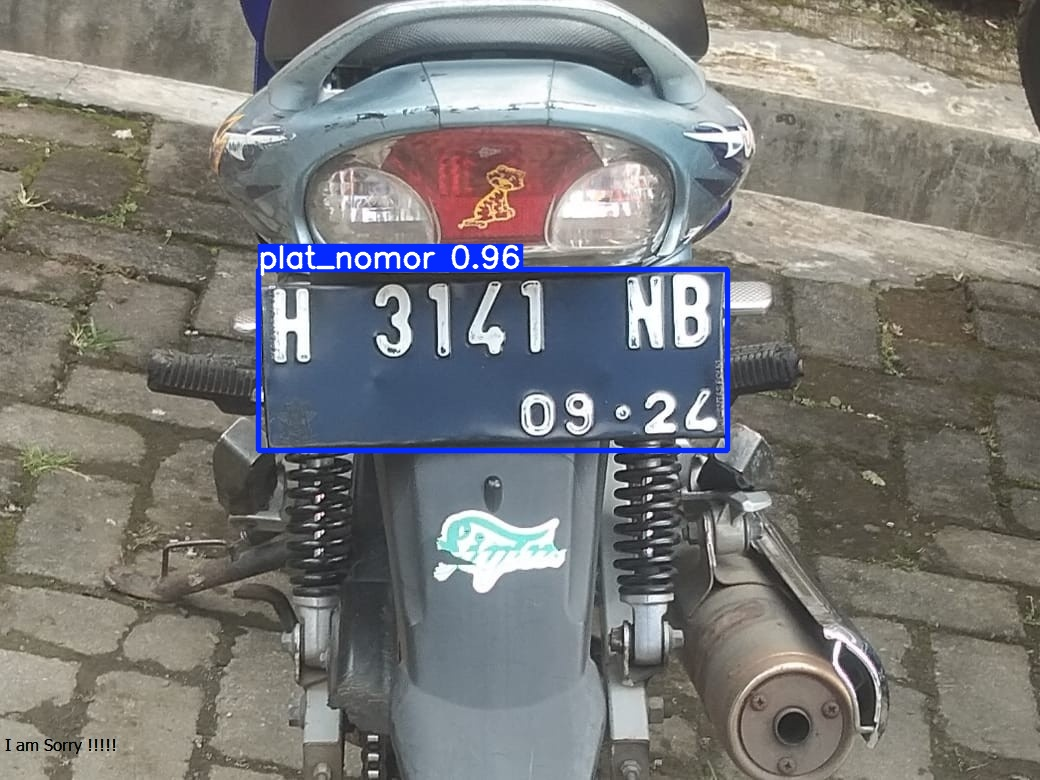

In [ ]:
# Upload file gambar
from google.colab import files
uploaded = files.upload()

# Ambil nama file yang di-upload
file_name = list(uploaded.keys())[0]

# Load model YOLOv8
from ultralytics import YOLO

# Ganti path sesuai lokasi model kamu
model = YOLO("runs/detect/yolo8-plat/weights/best.pt")

# Jalankan prediksi
results = model.predict(
    source=file_name,  # gambar yang di-upload
    conf=0.25,         # confidence threshold
    save=True          # simpan hasil deteksi ke folder runs/detect/predict/
)

# Tampilkan hasil
from IPython.display import Image, display

# Path hasil gambar (predict, predict2, dst jika sudah ada sebelumnya)
output_path = f"runs/detect/predict/{file_name}"

display(Image(filename=output_path))

# **Kesimpulan Object detectio**n

**Kesimpulan Hasil Training**

Model YOLOv8 telah dilatih untuk mendeteksi plat nomor kendaraan dengan hasil yang sangat baik pada dataset validasi.
Hasil metrik utama selama training adalah sebagai berikut:

* **Precision (B)**: 98.29% → Model mampu meminimalkan false positive dengan sangat baik.
* **Recall (B)**: 95.78% → Hampir seluruh plat nomor pada data validasi berhasil dideteksi.
* **mAP50 (B)**: 98.74% → Model memiliki akurasi tinggi dalam mendeteksi objek pada IoU ≥ 50%.
* **mAP50-95 (B)**: 95.34% → Akurasi rata-rata pada berbagai tingkat IoU tetap tinggi.
* **Fitness**: 95.68% → Skor gabungan yang menunjukkan kualitas model secara keseluruhan.

Model disimpan di direktori:

```
runs/detect/yolo8-plat/weights/best.pt
```

---

**Kesimpulan Hasil Testing**

Model kemudian diuji pada dataset uji (test set) untuk mengevaluasi kemampuan generalisasi terhadap data baru.
Hasil metrik pada test set adalah:

* **Precision (B)**: 98.27% → Model tetap presisi pada data baru.
* **Recall (B)**: 100% → Semua plat nomor pada test set berhasil dideteksi tanpa ada yang terlewat.
* **mAP50 (B)**: 98.98% → Akurasi deteksi bounding box sangat tinggi.
* **mAP50-95 (B)**: 93.93% → Model tetap akurat pada berbagai tingkat IoU.
* **Fitness**: 94.43% → Skor gabungan yang menunjukkan performa sangat baik pada test set.

Model diuji pada:

* **Jumlah objek (plat\_nomor)**: 62
* **Jumlah rata-rata objek per gambar**: 59

---

**Kesimpulan Akhir**

📌 Model YOLOv8 yang dilatih berhasil mendeteksi plat nomor kendaraan dengan **tingkat presisi dan recall yang sangat tinggi**, baik pada data validasi maupun data uji.
📌 Model menunjukkan kemampuan **generalize** dengan baik, sehingga layak digunakan untuk deployment pada sistem deteksi plat nomor secara real-time.

Code dibawah ini digunakan untuk melatih model CNN (Convolutional Neural Network) menggunakan dataset karakter (huruf/angka) dari plat nomor, agar model bisa mengenali karakter tersebut di gambar. Ini adalah bagian dari proses OCR untuk mengenali teks pada plat nomor kendaraan.